# 0: Sentences Defining Event Boundaries
# I: Social Primed Participants
# II: Location Primed Participants
# III: Graphing
# IV: Exporting


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import xlrd
import pickle
import seaborn as sb

%autosave 5

#import Alex-scored free recall sheets for story 43
xls43 = pd.ExcelFile('/Users/alexreblando/Documents/GitHub/data_analysis_ebs/12_LINAN.xlsx')

#get sheet names
xls = xlrd.open_workbook(r'/Users/alexreblando/Documents/GitHub/data_analysis_ebs/12_LINAN.xlsx', on_demand=True)
sheet_names = xls.sheet_names()

#which story
this_story = '12'

#import story stats in order to get story lengths
pickle_in = open("story_stats.pickle","rb")
story_stats = pickle.load(pickle_in)

#import story boundaries to get putative event boundaries
pickle_in = open("story_boundaries.pickle","rb")
story_boundaries = pickle.load(pickle_in)

#import subj_schemas matrix so that for each story for each subject you can know if they are
#social or location primed
pickle_in = open("subj_schemas.pickle","rb")
subj_schemas = pickle.load(pickle_in)

#Dictionary of scored sheets of individual participants
rs_dict = {}

for name in sheet_names:
    rs_dict[name] = pd.read_excel(xls43, name)   

Autosaving every 5 seconds


# 0: Sentences defining event boundaries
## Step 1: Social Events
## Step 2: Location Events

In [2]:
# Step 1: Determining the story sentences that mark the boundaries of each social event
soc_event = {}

#make the dictionary of all the events
for i in range(1,5):
    soc_event[i] = np.zeros((1,3))

count = 1
for j in range(len(story_boundaries[this_story])):
    if story_boundaries[this_story][j, 1] == 1:
        if count == 1:
            soc_event[count][0,0] = 1
            count = 2
        else:
            soc_event[count-1][0,1] = j
            soc_event[count][0,0] = j+1
            count += 1
        
soc_event[4][0,1] = len(story_boundaries[this_story]) 

#length of each event
for i in range(1,5):
    soc_event[i][0,2] = soc_event[i][0,1] - soc_event[i][0,0] + 1

In [3]:
# Step 2: Determining the story sentences that define the location events
loc_event = {}

#make the dictionary of all the events
for i in range(1,5):
    loc_event[i] = np.zeros((1,3))

count = 1
for j in range(len(story_boundaries[this_story])):
    if story_boundaries[this_story][j, 0] == 1:
        if count == 1:
            loc_event[count][0,0] = 1
            count = 2
        else:
            loc_event[count-1][0,1] = j
            loc_event[count][0,0] = j+1
            count += 1
            
        
loc_event[4][0,1] = len(story_boundaries[this_story]) 

#length of each event
for i in range(1,5):
    loc_event[i][0,2] = loc_event[i][0,1] - loc_event[i][0,0] + 1

# II: Social Primed Participants
## Step 1: Participant x Story Sentence matrix
## Step 2 : Social Event Starts: first sentence recall average for each event
## Step 3: Location Events Starts: first sentence recall average for each event
## Step 4: Non-event-start sentences
## Step 5: Average of all events

In [4]:
#Step 1: make a participant x story sentence matrix with '1' values for sentences that that 
#participant mentioned in their free recall for social primed participants

#find the number of sentences in story 43
n_sent = story_stats[this_story][3]

#the number of social primed participants
n_social = (sum( x == 'Social' for x in subj_schemas[this_story].values()))

#make empty participant x story sentences matrix
soc_subj_sent_m = np.zeros((n_social, n_sent))
count = 0
for name in sheet_names:
    if subj_schemas[this_story][name] == 'Social':
        for i in range(n_sent):
            val = np.sum(rs_dict[name][i+1])
            if val > 0:
                val = 1
            soc_subj_sent_m[count, i] = val
        count += 1

In [5]:
#Step 2: Social Event Starts: first sentence count for each event
#output: SP_SE = [avg recall for 1st event, " second event, " third event]
SP_SE = []

for i in range(2,5):
    this_column = int(soc_event[i][0,0] - 1)
    sum_recall = sum(soc_subj_sent_m[:, this_column])    
    avg_recall = sum_recall/n_social
    SP_SE.append(avg_recall)

In [6]:
#Step 3: Location Event Starts: first sentence count for each event
#output: SP_LE = [avg recall for 1st event, " second event, " third event]
SP_LE = []

for i in range(2,5):
    this_column = int(loc_event[i][0,0] - 1)
    sum_recall = sum(soc_subj_sent_m[:, this_column])    
    avg_recall = sum_recall/n_social
    SP_LE.append(avg_recall)

In [7]:
#Step 4: Non-event-Start sentences

non_start_cols = []
for i in range(0, len(story_boundaries[this_story])):
    tag = 0
    for j in range(2,5):
        if i == int(soc_event[j][0,0] - 1):
            tag += 1
        elif i == int(loc_event[j][0,0] - 1):
            tag += 1
    if tag == 0:
        sum_recall = sum(soc_subj_sent_m[:, i])    
        avg_recall = sum_recall/n_social
        non_start_cols.append(avg_recall)

In [8]:
#Step 5: Averages of all sentence types
#output: SP_avg_all_sents= [social-event-starts, location-event-starts, non-event-starts]

SP_avg_all_sents = [statistics.mean(SP_SE), statistics.mean(SP_LE), statistics.mean(non_start_cols)]

# II: Location Primed Participants
## Step 1: Participant x Story Sentence matrix
## Step 2 : Social Event Starts: first sentence recall average for each event
## Step 3: Location Events Starts: first sentence recall average for each event
## Step 4: Non-event-start sentences
## Step 5: Average of all events

In [9]:
#Step 1: make a participant x story sentence matrix with '1' values for sentences that that 
#participant mentioned in their free recall for social primed participants

priming_type = 'Location'

#find the number of sentences in the story
n_sent = story_stats[this_story][3]

#the number of social primed participants
n_location = (sum( x == priming_type for x in subj_schemas[this_story].values()))

#make empty participant x story sentences matrix
loc_subj_sent_m = np.zeros((n_location, n_sent))
count = 0
for name in sheet_names:
    if subj_schemas[this_story][name] == priming_type:
        for i in range(n_sent):
            val = np.sum(rs_dict[name][i+1])
            if val > 0:
                val = 1
            loc_subj_sent_m[count, i] = val
        count += 1

In [10]:
#Step 2: Social Event Starts: first sentence count for each event
#output: SP_SE = [avg recall for 1st event, " second event, " third event]
LP_SE = []

for i in range(2,5):
    this_column = int(soc_event[i][0,0] - 1)
    sum_recall = sum(loc_subj_sent_m[:, this_column])    
    avg_recall = sum_recall/n_location
    LP_SE.append(avg_recall)

In [11]:
#Step 3: Location Event Starts: first sentence count for each event
#output: SP_LE = [avg recall for 1st event, " second event, " third event]
LP_LE = []

for i in range(2,5):
    this_column = int(loc_event[i][0,0] - 1)
    sum_recall = sum(loc_subj_sent_m[:, this_column])    
    avg_recall = sum_recall/n_location
    LP_LE.append(avg_recall)

In [12]:
#Step 4: Non-event-Start sentences

LP_non_start_cols = []
for i in range(0, len(story_boundaries[this_story])):
    tag = 0
    for j in range(2,5):
        if i == int(soc_event[j][0,0] - 1):
            tag += 1
        elif i == int(loc_event[j][0,0] - 1):
            tag += 1
    if tag == 0:
        sum_recall = sum(loc_subj_sent_m[:, i])    
        avg_recall = sum_recall/n_location
        LP_non_start_cols.append(avg_recall)

In [13]:
#Step 5: Averages of all sentence types
#output: SP_avg_all_sents= [social-event-starts, location-event-starts, non-event-starts]

LP_avg_all_sents = [statistics.mean(LP_SE), statistics.mean(LP_LE), statistics.mean(LP_non_start_cols)]

# III: Graphing
## Step 1: Graph of the averages of the sentence types for each priming group

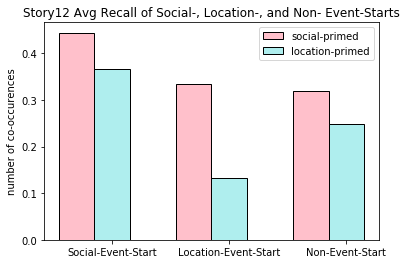

In [14]:
#Step 1: Graph of the averages of the sentence types for each priming group
#input: SP_avg_all_sents, SP_avg_all_sents

# width of the bars
barWidth = 0.3
 
#SP_avg_all_sents
bars1 = SP_avg_all_sents
 
bars2 = LP_avg_all_sents
    
#SP_soc_event
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'pink', edgecolor = 'black', label='social-primed')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'paleturquoise', edgecolor = 'black', label='location-primed')
 
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['Social-Event-Start', 'Location-Event-Start', 'Non-Event-Start'])
plt.ylabel('number of co-occurences')
plt.legend()
plt.title('Story' + this_story + ' Avg Recall of Social-, Location-, and Non- Event-Starts')
 
# Show graphic
plt.show()

# IV: Exporting

In [21]:
# IV: Exporting
## Step 1: Create a dict of all the variables and
#export the averages of each individual event of each type
import pickle

dict12 = {}
dict12['SP_SE'] = SP_SE
dict12['SP_LE'] = SP_LE
dict12['LP_SE'] = LP_SE
dict12['LP_LE'] = LP_LE
dict12['non_start_cols'] = non_start_cols
dict12['LP_non_start_cols'] = LP_non_start_cols

pickle_out = open("12dict","wb")
pickle.dump(dict12, pickle_out)
pickle_out.close()